(c) Red Kurti, 2024. All rights reserved

# MODELING

This notebook is part of the final project for the course STAT206: Statistical Computing at UCR, under the supervision of Professor Alfonso Landeros and TA Noe Vidales.

### Environment Setup

In [1]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 10 × Apple M1 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores
Environment:
  JULIA_NUM_THREADS = 


In [2]:
import Pkg
Pkg.activate(pwd())
Pkg.status()

  Activating project at `~/Library/CloudStorage/OneDrive-Personal/UCR/academics/winter_24/STAT206/project`


Status `~/Library/CloudStorage/OneDrive-Personal/UCR/academics/winter_24/STAT206/project/Project.toml`
  [324d7699] CategoricalArrays v0.10.8
  [7806a523] DecisionTree v0.12.4
  [31c24e10] Distributions v0.25.107
  [89b67f3b] ExcelFiles v1.0.0
  [da1fdf0e] FreqTables v0.4.6
  [38e38edf] GLM v1.9.0
  [09f84164] HypothesisTests v0.11.0
  [c709b415] Imbalance v0.1.5
  [add582a8] MLJ v0.20.3
  [a7f614a8] MLJBase v1.1.2
  [c6f25543] MLJDecisionTreeInterface v0.4.1
  [caf8df21] MLJGLMInterface v0.3.7
  [6ee0df7b] MLJLinearModels v0.10.0
  [d491faf4] MLJModels v0.16.16
  [5ae90465] MLJScikitLearnInterface v0.6.1
  [03970b2e] MLJTuning v0.8.2
  [54119dfa] MLJXGBoostInterface v0.3.10
  [636a865e] NearestNeighborModels v0.2.3
  [91a5bcdd] Plots v1.40.2
  [ce6b1742] RDatasets v0.7.7
  [8e980c4a] Shapefile v0.12.0
  [860ef19b] StableRNGs v1.0.1
  [2913bbd2] StatsBase v0.34.2
  [3eaba693] StatsModels v0.7.3
  [f3b207a7] StatsPlots v0.15.7
  [009559a3] XGBoost v2.5.1
  [9a3f8284] Random


In [3]:
# Color theme
primary_color = "#191919ff"
secondary_color = "#c67812ff"

"#c67812ff"

### Importing Libraries

In [4]:
# Data
using CSV, DataFrames, CategoricalArrays
# Statistics
using StableRNGs
# Visualization
using Plots
# ML Base
using MLJ, MLJModels, MLJBase, MLJTuning
# ML Linear
using MLJLinearModels
# ML Nearest Neighbors
using NearestNeighborModels
# ML Random Forest
using MLJDecisionTreeInterface

# Load the LogisticClassifier model from the MLJLinearModels package
@load LogisticClassifier pkg = MLJLinearModels verbosity = 0
@load KNNClassifier pkg=NearestNeighborModels verbosity=0
XGBoostClassifier = @load XGBoostClassifier pkg=XGBoost

import MLJXGBoostInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/redx/.julia/packages/MLJModels/55VdT/src/loading.jl:159


MLJXGBoostInterface.XGBoostClassifier

### Loading Data

1. Standardized data, class imbalanced

In [5]:
# Load the the data csv file from the /data directory
telco = DataFrame(CSV.File("data/telco_standardized.csv"))

# Peek at the first 5 rows of the dataframe
first(telco, 5) |> pretty

┌────────────┬────────────┬────────────────┬──────────────┬────────────────────┬─────────────────────┬─────────────┬──────────────┬────────────────┬─────────────────┬───────────────┬───────────────────┬────────────────────┬────────────────────┬──────────────────────────────────┬─────────────────────┬───────────────────────┬───────────────────────────────┬──────────────────────┬───────────────────────┬────────────────────────────────────────┬────────────────────────┬──────────────────┬───────────────────────────────────┬───────────────────┬──────────────────────────┬────────────────────┬────────────────────┬───────────────────────┬────────────────────────┬───────────────────────────────────────────┬─────────────────────────────────────────┬──────────────────────────────────┬──────────────────────────────┬─────────────────┬───────────────┬─────────────┬────────────┐
│ latitude   │ longitude  │ gender__Female │ gender__Male │ senior_citizen__No │ senior_citizen__Yes │ partner__No │ partne

2. Standardized data, class balancing using undersampling of the majority class

In [6]:
# Load the the data csv file from the /data directory
telco_balanced_undersampling = DataFrame(CSV.File("data/telco_balanced_undersampling.csv"))

# Peek at the first 5 rows of the dataframe
first(telco_balanced_undersampling, 5) |> pretty

┌────────────┬────────────┬────────────────┬──────────────┬────────────────────┬─────────────────────┬─────────────┬──────────────┬────────────────┬─────────────────┬───────────────┬───────────────────┬────────────────────┬────────────────────┬──────────────────────────────────┬─────────────────────┬───────────────────────┬───────────────────────────────┬──────────────────────┬───────────────────────┬────────────────────────────────────────┬────────────────────────┬──────────────────┬───────────────────────────────────┬───────────────────┬──────────────────────────┬────────────────────┬────────────────────┬───────────────────────┬────────────────────────┬───────────────────────────────────────────┬─────────────────────────────────────────┬──────────────────────────────────┬──────────────────────────────┬─────────────────┬───────────────┬─────────────┬────────────┐
│ latitude   │ longitude  │ gender__Female │ gender__Male │ senior_citizen__No │ senior_citizen__Yes │ partner__No │ partne

3. Standardized data, class balancing using oversampling of the minority class (SMOTE)

In [7]:
# Load the the data csv file from the /data directory
telco_balanced_oversampling = DataFrame(CSV.File("data/telco_balanced_oversampling.csv"))

# Peek at the first 5 rows of the dataframe
first(telco_balanced_oversampling, 5) |> pretty

┌────────────┬────────────┬────────────────┬──────────────┬────────────────────┬─────────────────────┬─────────────┬──────────────┬────────────────┬─────────────────┬───────────────┬───────────────────┬────────────────────┬────────────────────┬──────────────────────────────────┬─────────────────────┬───────────────────────┬───────────────────────────────┬──────────────────────┬───────────────────────┬────────────────────────────────────────┬────────────────────────┬──────────────────┬───────────────────────────────────┬───────────────────┬──────────────────────────┬────────────────────┬────────────────────┬───────────────────────┬────────────────────────┬───────────────────────────────────────────┬─────────────────────────────────────────┬──────────────────────────────────┬──────────────────────────────┬─────────────────┬───────────────┬────────────┬─────────────┐
│ latitude   │ longitude  │ gender__Female │ gender__Male │ senior_citizen__No │ senior_citizen__Yes │ partner__No │ partne

### Splitting Data Helper Function

In [8]:
# Function that splits the data into training and testing sets, features and target
function split_data(df::DataFrame)

  # Use random seed for reproducibility
  rng = StableRNG(206)

  # Split the data into training and testing sets
  train, test = partition(df, 0.7, rng = rng, shuffle=true)


  # Split the training data into features and target
  X_train = train[!, Not(:churn_value)]
  y_train = coerce(train.churn_value, Multiclass)

  # Split the testing data into features and target
  X_test = test[!, Not(:churn_value)]
  y_test = coerce(test.churn_value, Multiclass)

  # Return all 4 subsets
  return X_train, y_train, X_test, y_test
end

split_data (generic function with 1 method)

### Defining Evaluation Metric Helper Function

In [9]:
# Define a function that takes in a model fit and returns the accuracy of the model
function metrics(model_name, predictions, y, threshold)

  # Make predictions
  p_hat = pdf.(predictions, 1)

  # Convert to binary
  y_hat = p_hat .> threshold

  TP = sum((y_hat .== 1) .& (y .== 1))
  TN = sum((y_hat .== 0) .& (y .== 0))
  FP = sum((y_hat .== 1) .& (y .== 0))
  FN = sum((y_hat .== 0) .& (y .== 1))

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * precision * recall / (precision + recall)
  area_under_curve = auc(predictions, y)

  # Create a DataFrame to store the metrics
  results = DataFrame(
    model = [model_name],
    accuracy = [round(accuracy, digits=3)],
    precision = [round(precision, digits=3)],
    recall = [round(recall, digits=3)],
    f1 = [round(f1, digits=3)],
    auc = [round(area_under_curve, digits=3)]
  )

  return results

end

metrics (generic function with 1 method)

#### Metrics

In [10]:
# Define a function that takes model metrics and stores in a DataFrame
all_model_metrics = DataFrame(
  model = String[],
  accuracy = Float64[],
  precision = Float64[],
  recall = Float64[],
  f1 = Float64[],
  auc = Float64[]
)

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64


# 1. Logistic Regression Models
We build logistic regression models to predict the target variable, `y`. We first start with a baseline model, using the standardized data with class imbalance. We then build models using the standardized data with class balancing using undersampling and oversampling. We then address some of the common pitfalls of linear models, and try to improve on predictive performance.

## Model 1: The Baseline Model

#### Fitting the Model

In [11]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco)

# Build the machine
model_baseline = fit!(machine(LogisticClassifier(), X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @975 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @507 ⏎ AbstractVector{Multiclass{2}}


#### Evaluate the Model

In [12]:
# Make predictions
predictions = predict(model_baseline, X_test)
# Compute the metrics
model_baseline_metrics = metrics("GLM: Baseline", predictions, y_test, 0.5)
# Store the metrics in the DataFrame
push!(all_model_metrics, model_baseline_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859


#### Threshold Parameter Tuning
In classification models, the threshold can be used a tuning parameter to adjust the trade-off between precision and recall.

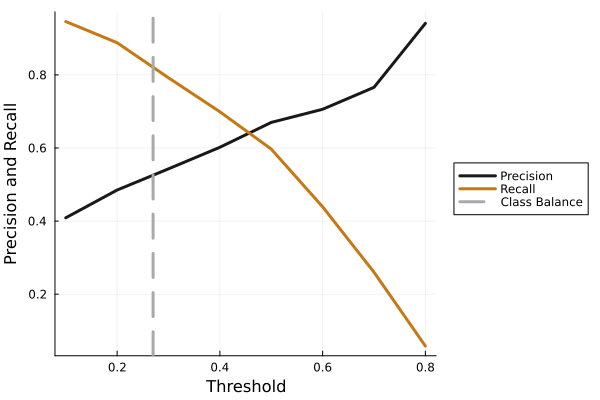

In [13]:
threshold_optimization = DataFrame(
  threshold = Float64[],
  precision = Float64[],
  recall = Float64[],
  f1 = Float64[],
)

for threshold in 0.1:0.1:0.8
  model_baseline_metrics = metrics("dummy", predictions, y_test, threshold)
  push!(threshold_optimization, (threshold, model_baseline_metrics.precision[1], model_baseline_metrics.recall[1], model_baseline_metrics.f1[1]))
end

# Plot the precision based on the threshold
threshold_optimization_plot = plot(
  xlabel="Threshold",
  ylabel="Precision and Recall",
  # title="Precision-Recall Tradeoff for Different Thresholds",
  legend=:outerright,
  bg=false
)

# Add precision to the plot based on the threshold
threshold_optimization_plot = plot!(
  threshold_optimization.threshold,
  threshold_optimization.precision,
  label="Precision",
  color=primary_color,
  linewidth=3,
)

# Add recall to the plot based on the threshold
threshold_optimization_plot = plot!(
  threshold_optimization.threshold,
  threshold_optimization.recall,
  label="Recall",
  color=secondary_color,
  linewidth=3,
)

# Add a vertical line at class balance
threshold_optimization_plot = vline!(
  [0.27],
  label="Class Balance",
  color=:darkgrey,
  linestyle=:dash,
  linewidth=3,
)

# Display the plot
threshold_optimization_plot

In [14]:
# Save the plot as .png
savefig(threshold_optimization_plot, "images/threshold_optimization_plot.png")

"/Users/redx/Library/CloudStorage/OneDrive-Personal/UCR/academics/winter_24/STAT206/project/images/threshold_optimization_plot.png"

In [15]:
threshold_optimization

Row,threshold,precision,recall,f1
,Float64,Float64,Float64,Float64
1,0.1,0.409,0.946,0.571
2,0.2,0.485,0.888,0.628
3,0.3,0.543,0.792,0.644
4,0.4,0.602,0.699,0.647
5,0.5,0.67,0.597,0.632
6,0.6,0.706,0.439,0.541
7,0.7,0.766,0.26,0.388
8,0.8,0.941,0.058,0.109


In [16]:
# Find which threshold gives the best f1 score
optimal_threshold = threshold_optimization[findfirst(threshold_optimization.f1 .== maximum(threshold_optimization.f1)), :threshold][1]

0.4

## Model 2: Optimal Threshold Model

In [17]:
# Compute the metrics
model_baseline_optimal_threshold_metrics = metrics(
  "GLM: Optimal Threshold",
  predictions,
  y_test,
  optimal_threshold
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_baseline_optimal_threshold_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859


## Model 2: Addressing Class Imbalance by Undersampling Majority Class

#### Fitting the Model

In [18]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_undersampling)

# Build the machine
model_balanced_undersampling = fit!(machine(LogisticClassifier(), X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @351 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @030 ⏎ AbstractVector{Multiclass{2}}


#### Evaluate the Model

In [19]:
# Make predictions
predictions = predict(model_balanced_undersampling, X_test)
# Compute the metrics
baseline_undersampling_metrics = metrics(
  "GLM: Undersampling",
  predictions,
  y_test,
  0.5
)
# Store the metrics in the DataFrame
push!(all_model_metrics, baseline_undersampling_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847


## Model 3: Addressing Class Imbalance by Oversampling Minority Class (SMOTE)

#### Fitting the Model

In [20]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

# Build the machine
model_balanced_oversampling = fit!(machine(LogisticClassifier(), X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @675 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @047 ⏎ AbstractVector{Multiclass{2}}


#### Evaluate the Model

In [21]:
# Make predictions
predictions = predict(model_balanced_oversampling, X_test)
# Compute the metrics
model_oversampling_metrics = metrics(
  "GLM: Oversampling",
  predictions,
  y_test,
  0.5
)
# Store the metrics in the DataFrame
push!(all_model_metrics, model_oversampling_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87


## Model 4: Regularization with Lasso

#### Fitting the Model with Optimal Hyperparameter

In [22]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

model_regularization = LogisticClassifier(penalty=:l1, lambda=1.0)

model_regularization_fit = fit!(machine(model_regularization, X_train, y_train), verbosity = 0)

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 1.0, …)
  args: 
    1:	Source @499 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @179 ⏎ AbstractVector{Multiclass{2}}


#### Tuning the Hyperparameter `lambda` helper function

In [23]:
function tuned_params(X_train::DataFrame, y_train::CategoricalArray)

  # Define the parameter range for lambda
  range_lambda = range(model_regularization, :lambda, lower=0.01, upper=100.0, scale=:log)

  # Setup a tuning strategy, e.g., Grid Search
  tuning = Grid(resolution=10)  # Adjust resolution as needed

  # Define the tuning experiment
  tuned_model = TunedModel(
    model=model_regularization,
    tuning=tuning,
    resampling=CV(),
    ranges=range_lambda,
    measure=log_loss
  )

  # Fit the tuned model
  tuned_model_fit = fit!(machine(tuned_model, X_train, y_train), verbosity=0)

  # Get the best lambda
  params = fitted_params(tuned_model_fit)

  return params
end

tuned_params (generic function with 1 method)

#### Tuning the Hyperparameter `lambda`

In [24]:
params = tuned_params(X_train, y_train)

best_lambda = params.best_model.lambda

coefficients = params.best_fitted_params.coefs |> DataFrame |> pretty

┌────────────┬────────────┬────────────────┬──────────────┬────────────────────┬─────────────────────┬─────────────┬──────────────┬────────────────┬─────────────────┬───────────────┬───────────────────┬────────────────────┬────────────────────┬──────────────────────────────────┬─────────────────────┬───────────────────────┬───────────────────────────────┬──────────────────────┬───────────────────────┬────────────────────────────────────────┬────────────────────────┬──────────────────┬───────────────────────────────────┬───────────────────┬──────────────────────────┬────────────────────┬────────────────────┬───────────────────────┬────────────────────────┬───────────────────────────────────────────┬─────────────────────────────────────────┬──────────────────────────────────┬──────────────────────────────┬─────────────────┬───────────────┬────────────┐
│ latitude   │ longitude  │ gender__Female │ gender__Male │ senior_citizen__No │ senior_citizen__Yes │ partner__No │ partner__Yes │ depen

In [25]:
intercept = params.best_fitted_params.intercept

-1.4270424258183725

#### Fitting the model with optimal hyperparameter

In [26]:
# Define the model with the best lambda
best_model = LogisticClassifier(penalty=:l1, lambda=best_lambda)

# Fit the best model
best_model_fit = fit!(machine(best_model, X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 0.010000000000000004, …)
  args: 
    1:	Source @576 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @820 ⏎ AbstractVector{Multiclass{2}}


#### Evaluate the Model

In [27]:
# Make predictions
predictions = predict(best_model_fit, X_test)

# Compute the metrics
tuned_model_metrics = metrics(
  "GLM: L1 Reguralization",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, tuned_model_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867


## Model 5: Forward Stepwise Selection

In [28]:
describe(telco_balanced_oversampling) |> pretty

┌───────────────────────────────────────────┬─────────────┬──────────────────────────┬────────────┬──────────────────────────┬──────────┬──────────┐
│ variable                                  │ mean        │ min                      │ median     │ max                      │ nmissing │ eltype   │
│ Symbol                                    │ Float64     │ Real                     │ Float64    │ Real                     │ Int64    │ DataType │
│ Unknown                                   │ Continuous  │ Union{Continuous, Count} │ Continuous │ Union{Continuous, Count} │ Count    │ Unknown  │
├───────────────────────────────────────────┼─────────────┼──────────────────────────┼────────────┼──────────────────────────┼──────────┼──────────┤
│ latitude                                  │ 0.000916545 │ -1.51763                 │ 0.0564237  │ 2.31211                  │ 0        │ Float64  │
│ longitude                                 │ -0.00383142 │ -2.08666                 │ 0.0191435  │ 2.5984

#### Stepwise Helper Function

In [29]:
function stepwise_selection(df::DataFrame, verbose::Bool = true)
  # Split the data
  X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

  # Initialize an empty model
  remaining_features = names(X_train) # Assuming X_train is a DataFrame
  selected_features = []

  subset_selection_results = DataFrame(
    step = Int[],
    feature = String[],
    train_accuracy = Float64[],
    test_accuracy = Float64[]
  )

  for step in 1:length(remaining_features)

    if verbose
      println("Step: $step")
    end

    best_feature = nothing
    best_train_accuracy = 0.0
    best_test_accuracy = 0.0

    for feature in remaining_features
        # Update the model to include the new feature
        current_features = [selected_features; feature]

        # Fit the model
        model_fit = fit!(machine(LogisticClassifier(), X_train[:, current_features], y_train), verbosity=0)

        # Training set results
        train_predictions = predict(model_fit, X_train[:, current_features])
        train_metrics = metrics("dummy", train_predictions, y_train, 0.5)
        train_accuracy = train_metrics.accuracy[1]

        # Testing set results
        test_predictions = predict(model_fit, X_test[:, current_features])
        test_metrics = metrics("dummy", test_predictions, y_test, 0.5)
        test_accuracy = test_metrics.accuracy[1]

        if test_accuracy > best_test_accuracy
            best_feature = feature
            best_test_accuracy = test_accuracy
            best_train_accuracy = train_accuracy
        end
    end

    # Break if no improvement
    if isnothing(best_feature)
        println("No improvement, stopping.")
        break
    end

    # Update selected and remaining features
    push!(selected_features, best_feature)
    push!(subset_selection_results, (step, best_feature, best_train_accuracy, best_test_accuracy))
    filter!(feature -> feature != best_feature, remaining_features)

    if verbose
        println("Selected feature: $best_feature, with Test Accuracy: $best_test_accuracy")
    end
  end

  return subset_selection_results
end

stepwise_selection (generic function with 2 methods)

#### Stepwise Plotting Helper Function

In [30]:
function plot_subset_selection_results(results::DataFrame)
  # Plot the accuracy of the model with the selected features
  subset_selection_plot = plot(
    xlabel="Number of Features",
    ylabel="Accuracy",
    legend=:outerright,
    bg=false
  )

  # Add the training accuracy to the plot
  subset_selection_plot = plot!(
    results.step,
    results.train_accuracy,
    label="Train Accuracy",
    color=primary_color,
    linewidth=3,
  )

  # Add the testing accuracy to the plot
  subset_selection_plot = plot!(
    results.step,
    results.test_accuracy,
    label="Test Accuracy",
    color=secondary_color,
    linewidth=3,
  )

  return subset_selection_plot
end

plot_subset_selection_results (generic function with 1 method)

#### Performing Forward Stepwise Selection

In [31]:
# Run the stepwise selection
subset_selection_result = stepwise_selection(telco_balanced_oversampling, false)

# Display the results
subset_selection_result |> pretty

┌───────┬───────────────────────────────────────────┬────────────────┬───────────────┐
│ step  │ feature                                   │ train_accuracy │ test_accuracy │
│ Int64 │ String                                    │ Float64        │ Float64       │
│ Count │ Textual                                   │ Continuous     │ Continuous    │
├───────┼───────────────────────────────────────────┼────────────────┼───────────────┤
│ 1     │ contract__Month-to-month                  │ 0.73           │ 0.731         │
│ 2     │ dependents__No                            │ 0.756          │ 0.766         │
│ 3     │ internet_service__No                      │ 0.767          │ 0.774         │
│ 4     │ tenure_months                             │ 0.767          │ 0.776         │
│ 5     │ internet_service__DSL                     │ 0.77           │ 0.78          │
│ 6     │ payment_method__Electronic check          │ 0.773          │ 0.786         │
│ 7     │ phone_service__No                

In [32]:
subset_selection_plot = subset_selection_result |> plot_subset_selection_results
savefig(subset_selection_plot, "images/subset_selection_plot.png")

"/Users/redx/Library/CloudStorage/OneDrive-Personal/UCR/academics/winter_24/STAT206/project/images/subset_selection_plot.png"

#### Fitting the Model with only the Selected Features

In [33]:
# Join the first 10 feautres in a string array
first_10_features = subset_selection_result[1:10, 2]

# Split the data
X_train, y_train, X_test, y_test = split_data(
  DataFrames.select(
    telco_balanced_oversampling,
    [first_10_features; "churn_value"]
  )
)

first_10_features

10-element Vector{String}:
 "contract__Month-to-month"
 "dependents__No"
 "internet_service__No"
 "tenure_months"
 "internet_service__DSL"
 "payment_method__Electronic check"
 "phone_service__No"
 "paperless_billing__No"
 "cltv"
 "senior_citizen__Yes"

In [34]:
model_subset = LogisticClassifier()
model_subset_fit = fit!(
  machine(
    model_subset,
    X_train,
    y_train
  ),
  verbosity = 0
)

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @915 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @535 ⏎ AbstractVector{Multiclass{2}}


#### Evaluate the Model

In [35]:
# Make predictions
predictions = predict(model_subset_fit, X_test)

# Compute the metrics
model_subset_metrics = metrics(
  "GLM: Subset Selection",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_subset_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868


# Random Forest Models

## Model 1: The Baseline Model

### Fitting the Model

In [36]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco)

# Build the machine with Random Forest Classifier
model_rf_baseline = RandomForestClassifier()

model_rf_baseline_fit = fit!(machine(model_rf_baseline, X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: RandomForestClassifier(max_depth = -1, …)
  args: 
    1:	Source @186 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @685 ⏎ AbstractVector{Multiclass{2}}


### Evaluating the Model

In [37]:
# Make predictions
predictions = predict(model_rf_baseline_fit, X_test)

# Compute the metrics
model_rf_baseline_metrics = metrics(
  "Random Forest: Baseline",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_rf_baseline_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868
7,Random Forest: Baseline,0.804,0.661,0.523,0.584,0.853


## Model 2: Addressing Class Imbalance

#### Fitting the Model

In [38]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

# Build the machine with Random Forest Classifier
model_rf_balanced = RandomForestClassifier()

model_rf_baseline_fit = fit!(machine(model_rf_balanced, X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: RandomForestClassifier(max_depth = -1, …)
  args: 
    1:	Source @519 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @101 ⏎ AbstractVector{Multiclass{2}}


#### Evaluating the Model

In [39]:
# Make predictions
predictions = predict(model_rf_baseline_fit, X_test)

# Compute the metrics
model_rf_baseline_metrics = metrics(
  "Random Forest: Oversampling",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_rf_baseline_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868
7,Random Forest: Baseline,0.804,0.661,0.523,0.584,0.853
8,Random Forest: Oversampling,0.865,0.856,0.885,0.87,0.942


## Model 3: Hyperparameter Tuning

#### Tuning

In [40]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

# Define the model
model_rf_tuned = RandomForestClassifier()

# Define the range for the number of trees
n_trees_range = range(model_rf_tuned, :n_trees, lower=10, upper=100)
max_depth_range = range(model_rf_tuned, :max_depth, lower=1, upper=30)
min_samples_split_range = range(model_rf_tuned, :min_samples_split, lower=2, upper=20)

tuned_model = TunedModel(
    model=model_rf_tuned,
    resampling=CV(nfolds=5),
    ranges=[n_trees_range, max_depth_range, min_samples_split_range],
    measure=accuracy,
    n=50,
)

ProbabilisticTunedModel(
  model = RandomForestClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = -1, 
        n_trees = 100, 
        sampling_fraction = 0.7, 
        feature_importance = :impurity, 
        rng = Random._GLOBAL_RNG()), 
  tuning = RandomSearch(
        bounded = Distributions.Uniform, 
        positive_unbounded = Distributions.Gamma, 
        other = Distributions.Normal, 
        rng = Random._GLOBAL_RNG()), 
  resampling = CV(
        nfolds = 5, 
        shuffle = false, 
        rng = Random._GLOBAL_RNG()), 
  measure = Accuracy(), 
  weights = nothing, 
  class_weights = nothing, 
  operation = nothing, 
  range = NumericRange{Int64, MLJBase.Bounded, Symbol}[NumericRange(10 ≤ n_trees ≤ 100; origin=55.0, unit=45.0), NumericRange(1 ≤ max_depth ≤ 30; origin=15.5, unit=14.5), NumericRange(2 ≤ min_samples_split ≤ 20; origin=11.0, unit=9.0)], 
  selection_heu

#### Fitting the Tuned Model

In [41]:
# Assuming X_train, y_train from your data preparation step
model_rf_tuned_fit = fit!(machine(tuned_model, X_train, y_train), verbosity = 0)

# Params
params = fitted_params(model_rf_tuned_fit)

(best_model = RandomForestClassifier(max_depth = 28, …),
 best_fitted_params = (forest = Ensemble of Decision Trees
Trees:      97
Avg Leaves: 699.8144329896908
Avg Depth:  26.47422680412371,),)

#### Evaluating the Tuned Model

In [42]:
model_rf_tuned_best_model = params.best_model

# Fit the best model
model_rf_tuned_best_model_fit = fit!(machine(model_rf_tuned_best_model, X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: RandomForestClassifier(max_depth = 28, …)
  args: 
    1:	Source @955 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @052 ⏎ AbstractVector{Multiclass{2}}


In [43]:
# Make predictions
predictions = predict(model_rf_tuned_best_model_fit, X_test)

# Compute the metrics
model_rf_tuned_metrics = metrics(
  "Random Forest: Hyperparameter Tuning",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_rf_tuned_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868
7,Random Forest: Baseline,0.804,0.661,0.523,0.584,0.853
8,Random Forest: Oversampling,0.865,0.856,0.885,0.87,0.942
9,Random Forest: Hyperparameter Tuning,0.865,0.847,0.899,0.873,0.94


# K-Nearest Neighbors Models

## Model 1: The Baseline Model

#### Fitting the model

In [44]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

# Define the model
model_knn_baseline = NearestNeighborModels.KNNClassifier()

# Fit the model
model_knn_baseline_fit = fit!(machine(model_knn_baseline, X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: KNNClassifier(K = 5, …)
  args: 
    1:	Source @711 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @696 ⏎ AbstractVector{Multiclass{2}}


#### Evaluating the model

In [45]:
# Make predictions
predictions = predict(model_knn_baseline_fit, X_test)

# Compute the metrics
model_knn_baseline_metrics = metrics(
  "K-Nearest Neighbors: Baseline",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_knn_baseline_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868
7,Random Forest: Baseline,0.804,0.661,0.523,0.584,0.853
8,Random Forest: Oversampling,0.865,0.856,0.885,0.87,0.942
9,Random Forest: Hyperparameter Tuning,0.865,0.847,0.899,0.873,0.94


## Model 2: Balancing Classes

#### Fitting the model

In [46]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

# Define the model
model_knn_oversampling = NearestNeighborModels.KNNClassifier()

# Fit the model
model_knn_oversampling_fit = fit!(machine(model_knn_oversampling, X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: KNNClassifier(K = 5, …)
  args: 
    1:	Source @342 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @518 ⏎ AbstractVector{Multiclass{2}}


#### Evaluating the model

In [47]:
# Make predictions
predictions = predict(model_knn_oversampling_fit, X_test)

# Compute the metrics
model_knn_oversampling_metrics = metrics(
  "K-Nearest Neighbors: Oversampling",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_knn_oversampling_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868
7,Random Forest: Baseline,0.804,0.661,0.523,0.584,0.853
8,Random Forest: Oversampling,0.865,0.856,0.885,0.87,0.942
9,Random Forest: Hyperparameter Tuning,0.865,0.847,0.899,0.873,0.94


## Model 3: Hyperparameter Tuning

#### Tuning

In [48]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

# Define the model
model_knn = NearestNeighborModels.KNNClassifier()

# We try to find the best k up to 20
k_range = range(model_knn, :K, lower=1, upper=20)

# Defining the grid
tuning_strategy = Grid(resolution=20)

# Define the tuning strategy
model_knn_tuned = TunedModel(
    model=model_knn,
    tuning=tuning_strategy,
    resampling=CV(nfolds=5),
    ranges=[k_range],
    measure=accuracy,
    operation=predict_mode,
    n=20
)

ProbabilisticTunedModel(
  model = KNNClassifier(
        K = 5, 
        algorithm = :kdtree, 
        metric = Euclidean(0.0), 
        leafsize = 10, 
        reorder = true, 
        weights = Uniform()), 
  tuning = Grid(
        goal = nothing, 
        resolution = 20, 
        shuffle = true, 
        rng = Random._GLOBAL_RNG()), 
  resampling = CV(
        nfolds = 5, 
        shuffle = false, 
        rng = Random._GLOBAL_RNG()), 
  measure = Accuracy(), 
  weights = nothing, 
  class_weights = nothing, 
  operation = MLJModelInterface.predict_mode, 
  range = NumericRange{Int64, MLJBase.Bounded, Symbol}[NumericRange(1 ≤ K ≤ 20; origin=10.5, unit=9.5)], 
  selection_heuristic = NaiveSelection(nothing), 
  train_best = true, 
  repeats = 1, 
  n = 20, 
  acceleration = CPU1{Nothing}(nothing), 
  acceleration_resampling = CPU1{Nothing}(nothing), 
  check_measure = true, 
  cache = true)

#### Fitting the model

In [49]:
# Fit the model
model_knn_tuned_fit = fit!(machine(model_knn_tuned, X_train, y_train), verbosity=1)

┌ Info: Training machine(ProbabilisticTunedModel(model = KNNClassifier(K = 5, …), …), …).
└ @ MLJBase /Users/redx/.julia/packages/MLJBase/eCnWm/src/machines.jl:493
┌ Info: Attempting to evaluate 20 models.
└ @ MLJTuning /Users/redx/.julia/packages/MLJTuning/CLXum/src/tuned_models.jl:729
Evaluating over 20 metamodels: 100%[=========================] Time: 0:00:09


trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = KNNClassifier(K = 5, …), …)
  args: 
    1:	Source @619 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @321 ⏎ AbstractVector{Multiclass{2}}


In [50]:
# Get the best k
params = fitted_params(model_knn_tuned_fit)
best_k = params.best_model.K

1

#### Evaluating the model

In [51]:
# Make predictions
predictions = predict(model_knn_tuned_fit, X_test)

# Compute the metrics
model_knn_tuned_metrics = metrics(
  "K-Nearest Neighbors: Hyperparameter Tuning",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_knn_tuned_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868
7,Random Forest: Baseline,0.804,0.661,0.523,0.584,0.853
8,Random Forest: Oversampling,0.865,0.856,0.885,0.87,0.942
9,Random Forest: Hyperparameter Tuning,0.865,0.847,0.899,0.873,0.94


# XGBoost Models

## Model 1: Balancing Classes

#### Fitting the model

In [52]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

# Define the model
model_xgb_balanced = XGBoostClassifier()

# Fit the model
model_xgb_balanced_fit = fit!(machine(model_xgb_balanced, X_train, y_train), verbosity=0)

trained Machine; caches model-specific representations of data
  model: XGBoostClassifier(test = 1, …)
  args: 
    1:	Source @419 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @344 ⏎ AbstractVector{Multiclass{2}}


In [53]:
best_features = feature_importances(model_xgb_balanced_fit)

28-element Vector{Pair{Symbol, Float32}}:
                Symbol("contract__Month-to-month") => 117.64085
           Symbol("internet_service__Fiber optic") => 22.227396
                                   :dependents__No => 22.098532
        Symbol("payment_method__Electronic check") => 13.937189
                                 :tech_support__No => 9.693799
                      Symbol("contract__Two year") => 8.707777
                            :paperless_billing__No => 7.596537
                      Symbol("contract__One year") => 6.2016234
                               :multiple_lines__No => 5.3117175
 Symbol("payment_method__Credit card (automatic)") => 5.0322046
                                                   ⋮
                           :device_protection__Yes => 2.8750942
                            :internet_service__DSL => 2.6524317
                                  :monthly_charges => 2.5880418
                                        :longitude => 2.1900978
            

#### Evaluating the model

In [54]:
# Make predictions
predictions = predict(model_xgb_balanced_fit, X_test)

# Compute the metrics
model_xgb_balanced_metrics = metrics(
  "XGBoost: Oversampling",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_xgb_balanced_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868
7,Random Forest: Baseline,0.804,0.661,0.523,0.584,0.853
8,Random Forest: Oversampling,0.865,0.856,0.885,0.87,0.942
9,Random Forest: Hyperparameter Tuning,0.865,0.847,0.899,0.873,0.94


## Model 2: Hypertuning Parameters

#### Tuning

In [55]:
# Split the data
X_train, y_train, X_test, y_test = split_data(telco_balanced_oversampling)

# Define the model
model_xgb = XGBoostClassifier()

# Define Ranges
eta_range = range(model_xgb, :eta, lower=0.01, upper=0.3)
max_depth_range = range(model_xgb, :max_depth, lower=3, upper=10)

model_xgb_tuned = TunedModel(
    model=model_xgb,
    resampling=CV(nfolds=5),
    ranges=[eta_range, max_depth_range],
    measure=accuracy,
    operation=predict_mode,
    n=20
)

ProbabilisticTunedModel(
  model = XGBoostClassifier(
        test = 1, 
        num_round = 100, 
        booster = "gbtree", 
        disable_default_eval_metric = 0, 
        eta = 0.3, 
        num_parallel_tree = 1, 
        gamma = 0.0, 
        max_depth = 6, 
        min_child_weight = 1.0, 
        max_delta_step = 0.0, 
        subsample = 1.0, 
        colsample_bytree = 1.0, 
        colsample_bylevel = 1.0, 
        colsample_bynode = 1.0, 
        lambda = 1.0, 
        alpha = 0.0, 
        tree_method = "auto", 
        sketch_eps = 0.03, 
        scale_pos_weight = 1.0, 
        updater = nothing, 
        refresh_leaf = 1, 
        process_type = "default", 
        grow_policy = "depthwise", 
        max_leaves = 0, 
        max_bin = 256, 
        predictor = "cpu_predictor", 
        sample_type = "uniform", 
        normalize_type = "tree", 
        rate_drop = 0.0, 
        one_drop = 0, 
        skip_drop = 0.0, 
        feature_selector = "cyclic", 
        top

#### Fitting the tuned model

In [56]:
# Fit the model
model_xgb_tuned_fit = fit!(machine(model_xgb_tuned, X_train, y_train), verbosity=0)

trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = XGBoostClassifier(test = 1, …), …)
  args: 
    1:	Source @938 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @749 ⏎ AbstractVector{Multiclass{2}}


In [57]:
# Get the best parameters
params = fitted_params(model_xgb_tuned_fit)

(best_model = XGBoostClassifier(test = 1, …),
 best_fitted_params = (fitresult = (XGBoost.Booster(), CategoricalValue{Int64, UInt32} 1),),)

In [58]:
best_eta = params.best_model.eta
best_max_depth = params.best_model.max_depth

println("Best ETA: ", best_eta, "Best MAX DEPTH: ", best_max_depth)

Best ETA: 0.24753436556032415Best MAX DEPTH: 8


In [59]:
best_features = feature_importances(model_xgb_balanced_fit)

28-element Vector{Pair{Symbol, Float32}}:
                Symbol("contract__Month-to-month") => 117.64085
           Symbol("internet_service__Fiber optic") => 22.227396
                                   :dependents__No => 22.098532
        Symbol("payment_method__Electronic check") => 13.937189
                                 :tech_support__No => 9.693799
                      Symbol("contract__Two year") => 8.707777
                            :paperless_billing__No => 7.596537
                      Symbol("contract__One year") => 6.2016234
                               :multiple_lines__No => 5.3117175
 Symbol("payment_method__Credit card (automatic)") => 5.0322046
                                                   ⋮
                           :device_protection__Yes => 2.8750942
                            :internet_service__DSL => 2.6524317
                                  :monthly_charges => 2.5880418
                                        :longitude => 2.1900978
            

#### Evaluating the Model

In [60]:
# Make predictions
predictions = predict(model_xgb_tuned_fit, X_test)

# Compute the metrics
model_xgb_tuned_metrics = metrics(
  "XGBoost: Hyperparameter Tuning",
  predictions,
  y_test,
  0.5
)

# Store the metrics in the DataFrame
push!(all_model_metrics, model_xgb_tuned_metrics[1, :])

Row,model,accuracy,precision,recall,f1,auc
,String,Float64,Float64,Float64,Float64,Float64
1,GLM: Baseline,0.817,0.67,0.597,0.632,0.859
2,GLM: Optimal Threshold,0.8,0.602,0.699,0.647,0.859
3,GLM: Undersampling,0.767,0.752,0.809,0.78,0.847
4,GLM: Oversampling,0.787,0.773,0.827,0.799,0.87
5,GLM: L1 Reguralization,0.79,0.78,0.822,0.8,0.867
6,GLM: Subset Selection,0.793,0.783,0.825,0.804,0.868
7,Random Forest: Baseline,0.804,0.661,0.523,0.584,0.853
8,Random Forest: Oversampling,0.865,0.856,0.885,0.87,0.942
9,Random Forest: Hyperparameter Tuning,0.865,0.847,0.899,0.873,0.94


# Conclusion

In [61]:
# Print the results
all_model_metrics |> pretty

┌────────────────────────────────────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ model                                      │ accuracy   │ precision  │ recall     │ f1         │ auc        │
│ String                                     │ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │
│ Textual                                    │ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │
├────────────────────────────────────────────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│ GLM: Baseline                              │ 0.817      │ 0.67       │ 0.597      │ 0.632      │ 0.859      │
│ GLM: Optimal Threshold                     │ 0.8        │ 0.602      │ 0.699      │ 0.647      │ 0.859      │
│ GLM: Undersampling                         │ 0.767      │ 0.752      │ 0.809      │ 0.78       │ 0.847      │
│ GLM: Oversampling                          │ 0.787      │ 0.773      │ 0.827      │ 0.799      │ 0.87 